# Machine Learning

## L3T13 - Capstone Project 2

## Importing libraries, Data loading & Data Cleaning

In [1]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score, silhouette_score

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans

In [2]:
# Load data from CSV
UsArrests_df = pd.read_csv('UsArrests.csv')
print(UsArrests_df.shape)

UsArrests_df = UsArrests_df.drop_duplicates()
UsArrests_df = UsArrests_df.dropna()
print(UsArrests_df.shape)

UsArrests_df.head()


(50, 5)
(50, 5)


,City,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6


## Data Scaling

In [3]:
# Scale data and create dataframe
min_max_scaler = MinMaxScaler()
US_arrests_scaled = min_max_scaler.fit_transform(UsArrests_df.iloc[:, 1:5])
scaled_df= pd.DataFrame(US_arrests_scaled, columns = UsArrests_df.columns[1:5])
scaled_df.head()


,Murder,Assault,UrbanPop,Rape
0,0.746988,0.654110,0.440678,0.359173
1,0.554217,0.746575,0.271186,0.961240
2,0.439759,0.852740,0.813559,0.612403
3,0.481928,0.496575,0.305085,0.315245
4,0.493976,0.791096,1.000000,0.860465


## Principal Component Analysis

In [4]:
# Create heatmap function for PCA

def df_heatmap(df, dp, size):
  # get correlations
  #corrs = df.corr()
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
  # pick appropriate palette for heatmap

  # Plot figsize
    fig, ax = plt.subplots(figsize=(size, size))

  # to mask mirrored side of heatmap
    dropSelf = np.zeros_like(df)
    dropSelf[np.triu_indices_from(dropSelf)] = True

  # Generate Heat Map, with annotations of the correlation strength and 2-decimal floats
    if dp == 1:
        ax = sns.heatmap(df, cmap=colormap, annot=True, fmt=".2f", mask=dropSelf, linewidth=2)
    else:
        ax = sns.heatmap(df, cmap=colormap, fmt=".2f", linewidth=2)

    plt.show()


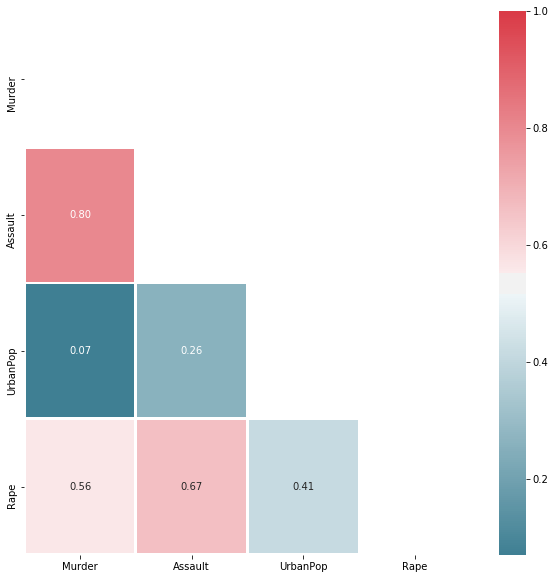

In [5]:
df_heatmap(scaled_df.corr(), 1, 10)

The heatmap indicates that urban population seems largely unrelated to any of the other variables. It also shows that murder and rape are related to assault.

Text(0, 0.5, 'cumulative explained variance')

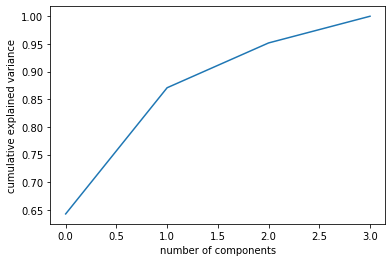

In [6]:
# Choose number of components
pca = PCA().fit(scaled_df)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

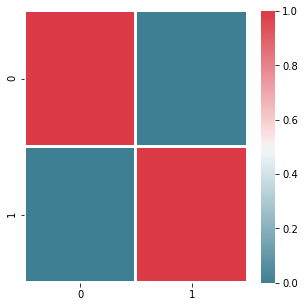

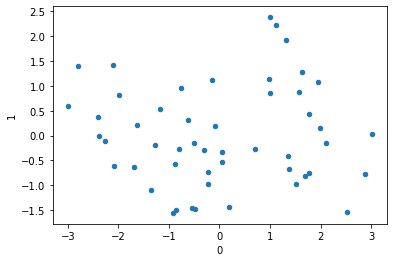

In [7]:
# select and standardize features
X = StandardScaler().fit_transform(scaled_df)

# choose number of components to be generated based on above heuristic
nr_comps = 2
pca = PCA(n_components = nr_comps)

# obtain components
principal_components = pca.fit_transform(X)

# transform the components into a pandas data frame
pca_df = pd.DataFrame(principal_components, index = scaled_df.index)

df_heatmap(pca_df.corr(), 0, 5)
# plot scatter
pca_df.plot.scatter(0, 1)

The heat map of the PCA parameters indicates that the 2 component PCA generated (2 new variables)  are  uncorrelated components and therefore more components are not required. This enables the  data to be presented on a  scatter plot. The scatter graph seems to indicate two clusters present when looked at.

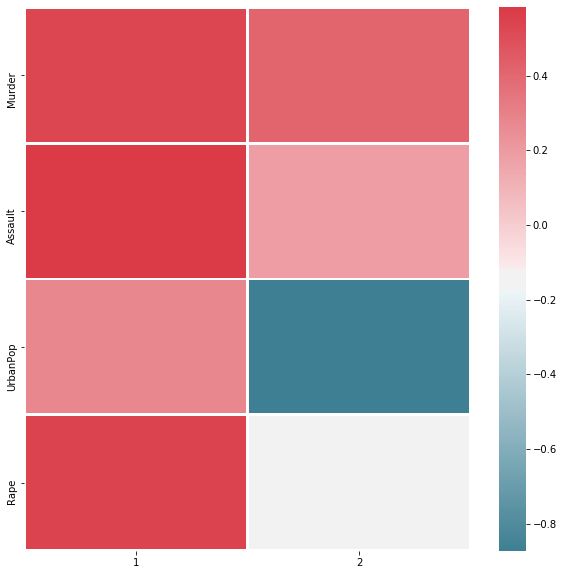

In [8]:
components = pd.DataFrame(pca.components_, columns=scaled_df.columns, index=range(1, nr_comps+1)).transpose()
df_heatmap(components, 0, 10)

The heatmap of the components against the original variables indicates that the first component has a positive relationship with all of the variables besides  the 'UrbanPop variable  whilst the second component has a strong negative correlation with 'UrbanPop' and weak relationships with 'Rape' and 'Assault' and a moderate relationship with 'Murder'.

## Cluster Models

In [9]:
# Define various methods used for visualisation

# Generate cluster plot for KMeans
def plot_Kmeans(x, k, r = 123):
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = r)
    y_pred = kmeans.fit_predict(x)
    colours = 'rbgcmy'
    k = kmeans.n_clusters
    for c in range(k):
        xp = x[y_pred == c]
        plt.plot(figsize = (10, 10))
        plt.scatter(xp[0], xp[1], c = colours[c], label = 'Cluster {}'.format(c))
        plt.scatter(kmeans.cluster_centers_[c, 0], kmeans.cluster_centers_[c, 1], marker = 'x', c = 'black')
    score = round(silhouette_score(x, kmeans.labels_, metric='euclidean'),3)
    plt.title('silhouette = {}'.format(score), loc='right', fontdict={'fontsize': 16}, pad = -14)
    plt.legend()
    plt.show()

# Generate cluster plot for Agglomerative clustering
def plot_AggC(x, k):
    cluster = AgglomerativeClustering(n_clusters = k, affinity = 'euclidean', linkage = 'complete')
    y_pred = cluster.fit_predict(x)
    colours = 'rbgcmy'
    k = cluster.n_clusters
    for c in range(k):
        xp = x[y_pred == c]
        plt.plot(figsize = (10, 10))
        plt.scatter(xp[0], xp[1], c = colours[c], label = 'Cluster {}'.format(c))
    score = round(silhouette_score(x, cluster.labels_, metric='euclidean'),3)
    plt.title('silhouette = {}'.format(score), loc='right', fontdict={'fontsize': 16}, pad = -14)
    plt.legend()
    plt.show()


# K Sensitivity analysis
def sens_analysis(modelt, K_min, K_max, X):
    score =[]
    for K in range(K_min, K_max +1):
        if modelt == 'KMeans':
            model = KMeans(n_clusters = K, init = 'k-means++', random_state = 123)
        else:
            model = AgglomerativeClustering(n_clusters = K, affinity = 'euclidean', linkage = 'complete')
        y_preds = model.fit_predict(X)
    
        score.append(silhouette_score(X, model.labels_, metric = 'euclidean'))
    plt.subplots(1, 1, figsize = (7, 7))
    plt.scatter(x = range(K_min, K_max +1), y = score)
    
    plt.xlabel('K')
    plt.ylabel('Silhouette Score')


### K-Means Clustering

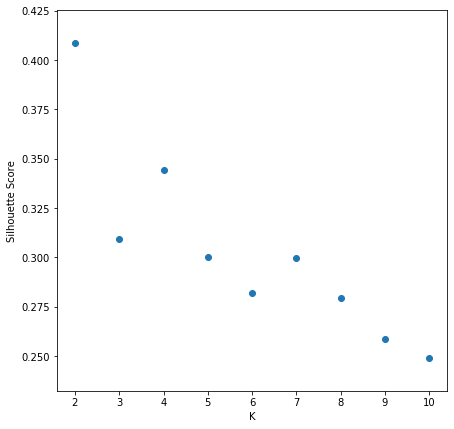

In [10]:
# K-means sensitivity analysis
sens_analysis('KMeans', 2, 10, X)


The K-Means clustering sensitivity analysis shows that the best silhouette will occur with 2 clusters that is with k = 2

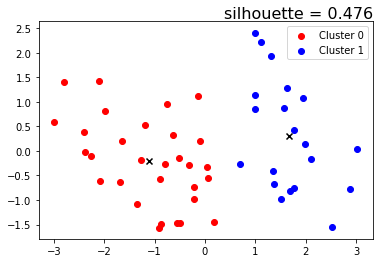

In [11]:
# Develop K-means model with k = 2 and plot clusters

plot_Kmeans(pca_df, 2, r=0)


The K-Means clustering model indicates that there are two clusters with a Silhouette score of 0.476.

### Agglomerative Clustering

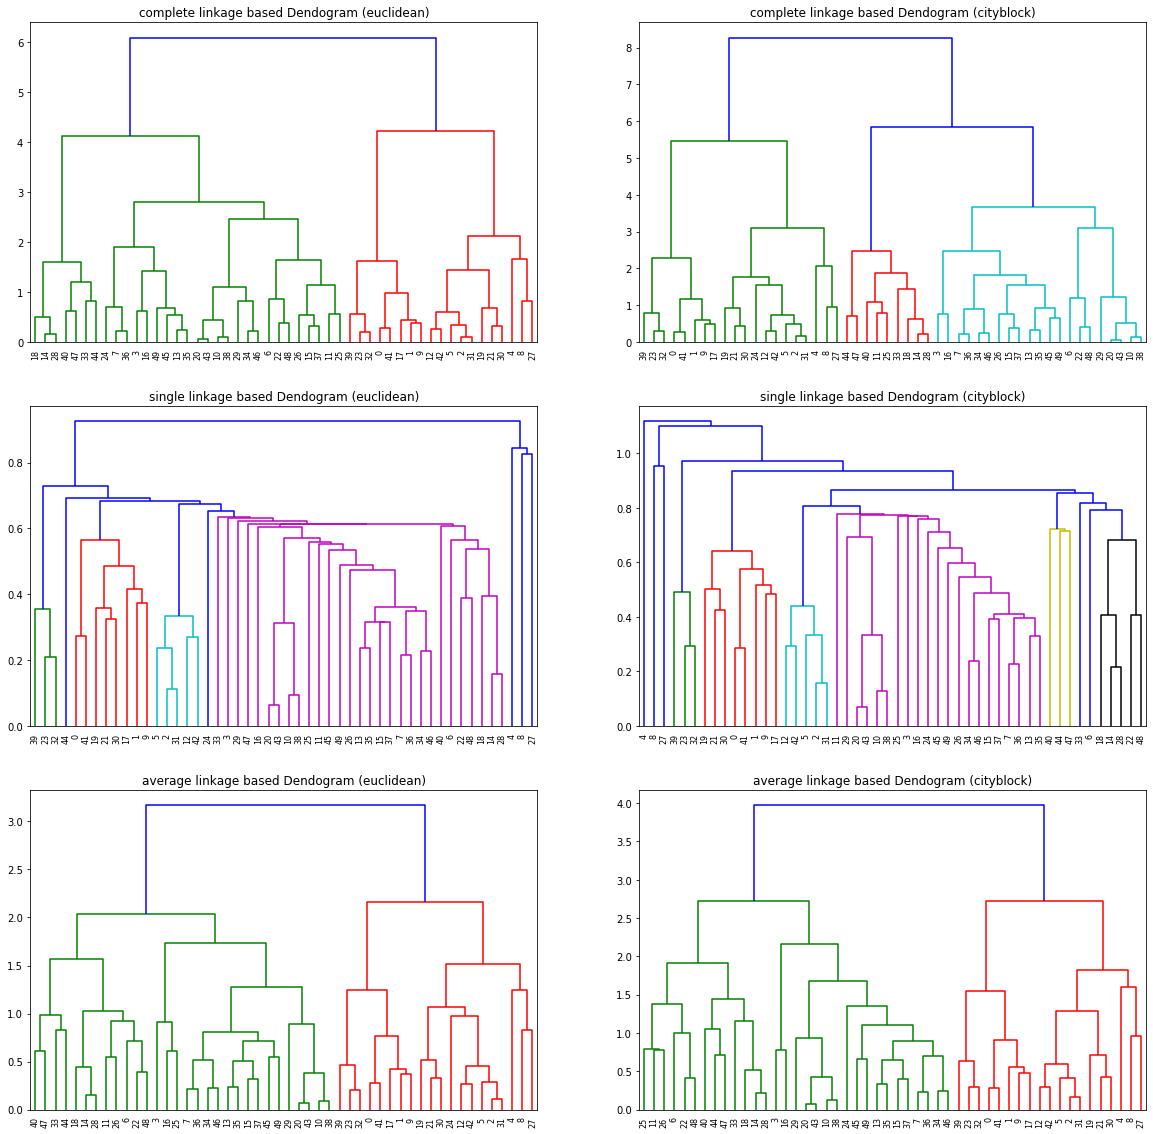

In [12]:
# Plot dendograms
# Choose methods and geometries to be evaluated

X = pca_df

method = ['complete', 'single','average']
geometry = ['euclidean', 'cityblock']

fig, axes = plt.subplots(3, 2, figsize = (20, 20))
p = 0

for meth in method: 
    for geom in geometry:
        p += 1
        plt.subplot(3, 2, p)
        plt.title(meth + ' linkage based Dendogram (' + geom + ')')  
        dend = dendrogram(linkage(X, method = meth, metric = geom)) 

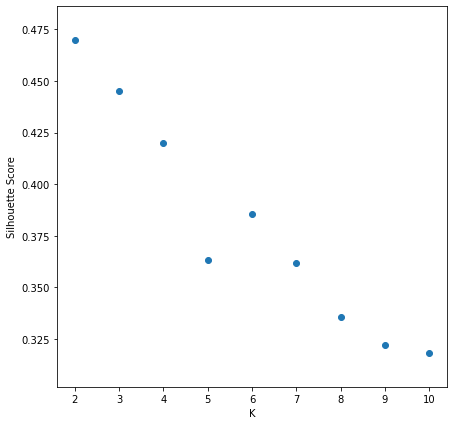

In [13]:
# K sensitivity analysis
sens_analysis('AgglomerativeClustering', 2, 10 , X)


Like the K- means, the agglomerative sensitivity analysis indicates that the number of clusters should be 2 . The dendograms also indicate that the smallest number of clusters that would work are 2 for the Euclidean complete linkage and the average linkage based denograms (Euclidean and cityblock).

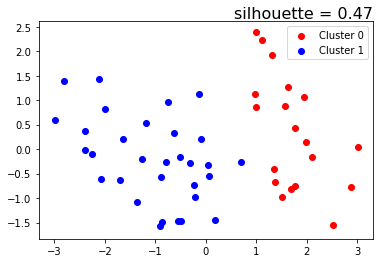

In [14]:
# Develop Agglomerative Cluster model and plot scatter
plot_AggC(pca_df, 2)


The Agglomerative Clustering method indicates that there are two clusters with a Silhouette score of 0.47. The difference between the two methods can be seen  as the point between the clusters moves from one cluster to the other in the two models (colours swap). The difference in Silhoutte score indicates that the K-Means model (0.476)  is slightly better than the Agglomerative Clustering (0.47) in these cases.